
# Breast Cancer Classification — CRISP-DM End‑to‑End Project

This notebook walks through a complete **CRISP-DM** workflow using scikit‑learn's **Breast Cancer Wisconsin** dataset.  
We will go from **Business Understanding** all the way to **Deployment ideas**, with a strong focus on **Data Understanding**, **Preparation**, **EDA**, **Modeling**, and **Evaluation**.

> **Why this dataset?** It is well‑curated, small enough to experiment quickly, and widely used to demonstrate binary classification workflows (benign vs malignant).

---



## 1) Business Understanding

**Goal:** Build a reliable model that predicts whether a tumor is **malignant** or **benign** based on diagnostic measurements (e.g., radius, texture, smoothness).

**Success Criteria**
- **Primary:** High recall for the malignant class (catch as many malignant cases as possible) while maintaining good precision.
- **Secondary:** Clear explainability about which features drive predictions.

**Constraints & Considerations**
- Medical context implies **false negatives are costly** (missing a malignant tumor).
- Model should be simple enough to explain to clinicians and stakeholders.
- Data is tabular and numeric; no PII included in this dataset.



## 2) Data Understanding

We load the dataset, inspect its shape, target distribution, and look for quirks like missing values or duplicate rows.


In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data_bunch = load_breast_cancer()
X = pd.DataFrame(data_bunch.data, columns=data_bunch.feature_names)
y = pd.Series(data_bunch.target, name="target")  # 0 = malignant, 1 = benign

X.shape, y.shape, y.value_counts(normalize=True).round(3)


((569, 30),
 (569,),
 target
 1    0.627
 0    0.373
 Name: proportion, dtype: float64)


**Notes:**
- The classes are coded as `0 = malignant`, `1 = benign`.
- We'll check for missing values, duplicates, and basic descriptive stats next.



## 3) Data Preparation (Cleaning & Feature Engineering)

**Plan**
1. Check for missing values and duplicates.
2. Basic outlier check via summary statistics.
3. Create a cleaned feature matrix (no ID columns exist here).
4. Train/validation split.


In [2]:

# Missing values?
missing = X.isna().sum().sort_values(ascending=False)
duplicates = X.duplicated().sum()

desc = X.describe().T

missing.head(), int(duplicates), desc.head()


(mean radius             0
 mean texture            0
 worst symmetry          0
 worst concave points    0
 worst concavity         0
 dtype: int64,
 0,
                  count        mean         std        min        25%  \
 mean radius      569.0   14.127292    3.524049    6.98100   11.70000   
 mean texture     569.0   19.289649    4.301036    9.71000   16.17000   
 mean perimeter   569.0   91.969033   24.298981   43.79000   75.17000   
 mean area        569.0  654.889104  351.914129  143.50000  420.30000   
 mean smoothness  569.0    0.096360    0.014064    0.05263    0.08637   
 
                        50%       75%        max  
 mean radius       13.37000   15.7800    28.1100  
 mean texture      18.84000   21.8000    39.2800  
 mean perimeter    86.24000  104.1000   188.5000  
 mean area        551.10000  782.7000  2501.0000  
 mean smoothness    0.09587    0.1053     0.1634  )


- The dataset typically has **no missing values**.
- Duplicates are unlikely but we verify.  
- We use summary statistics for a quick outlier scan; robust outlier handling would
  depend on domain input (clinical thresholds) and is not strictly necessary here.


In [3]:

# If duplicates existed, we would drop them like so:
X_clean = X.drop_duplicates()
# Align target after dropping any duplicates
if len(X_clean) != len(X):
    y = y.loc[X_clean.index]
    X = X_clean.reset_index(drop=True)
    y = y.reset_index(drop=True)

X_clean.shape


(569, 30)


## 4) Exploratory Data Analysis (EDA)

We'll visualize:
- Target balance
- Distributions for a few key features
- Correlation structure
  
> Plots use **matplotlib only** (no seaborn), one chart per figure, and no custom colors.


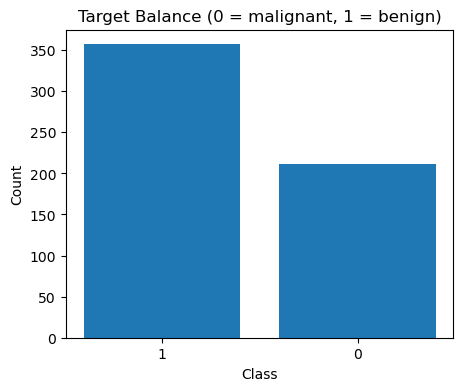

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# 4.1 Target balance
plt.figure(figsize=(5,4))
counts = y.value_counts()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target Balance (0 = malignant, 1 = benign)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


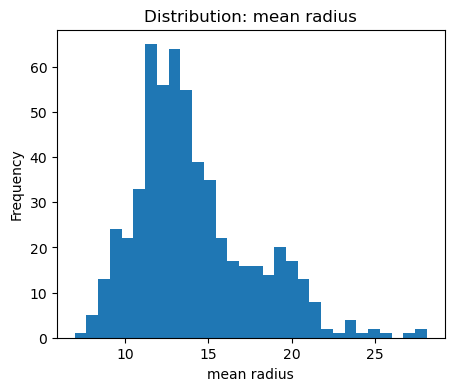

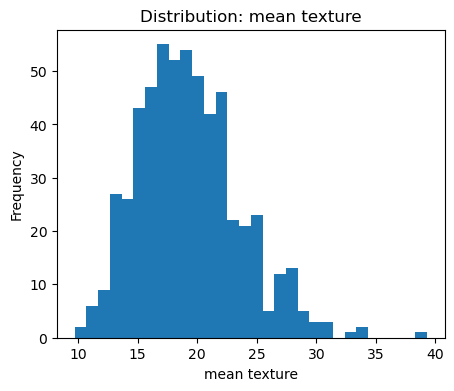

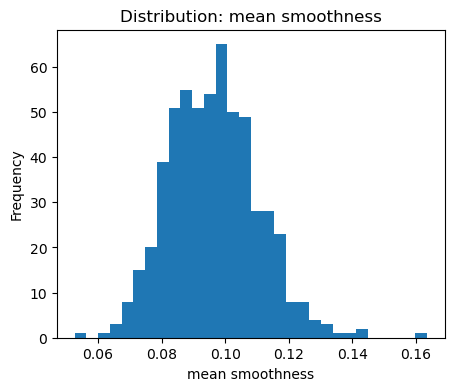

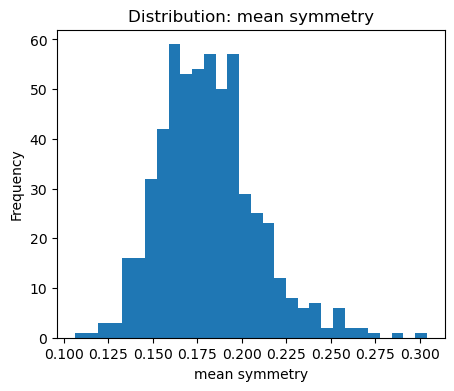

In [5]:

# 4.2 Histograms for a few representative features
features_to_plot = ["mean radius", "mean texture", "mean smoothness", "mean symmetry"]
for col in features_to_plot:
    plt.figure(figsize=(5,4))
    plt.hist(X[col], bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


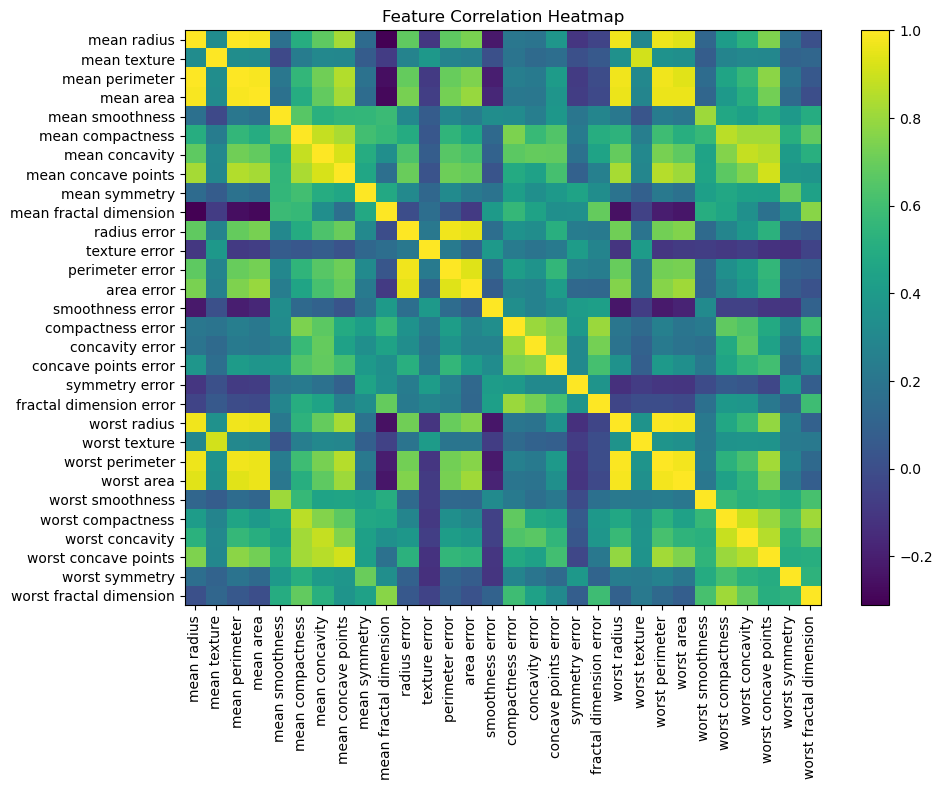

In [6]:

# 4.3 Correlation heatmap (matplotlib pcolormesh)
corr = X.corr().values
labels = X.columns.tolist()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.title("Feature Correlation Heatmap")
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
plt.tight_layout()
plt.show()



## 5) Modeling

We will compare two models:
1. **Logistic Regression** with standardization (simple, interpretable baseline).
2. **Random Forest** (nonlinear, handles interactions, feature importance).

We will perform an 80/20 train-test split and evaluate with accuracy, precision, recall, F1, ROC-AUC, and a confusion matrix.


In [7]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipelines
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=None))
])

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

logreg_pipe.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

def evaluate(model, X_te, y_te):
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_te)[:,1]
    elif hasattr(model, "decision_function"):
        # Convert decision function to a pseudo-probability via min-max scaling
        dec = model.decision_function(X_te)
        mn, mx = dec.min(), dec.max()
        proba = (dec - mn) / (mx - mn + 1e-9)
    y_pred = model.predict(X_te)
    metrics = dict(
        accuracy = accuracy_score(y_te, y_pred),
        precision = precision_score(y_te, y_pred),
        recall = recall_score(y_te, y_pred),
        f1 = f1_score(y_te, y_pred),
        roc_auc = roc_auc_score(y_te, proba) if proba is not None else float('nan')
    )
    return metrics, y_pred, proba

log_metrics, log_pred, log_proba = evaluate(logreg_pipe, X_test, y_test)
rf_metrics, rf_pred, rf_proba = evaluate(rf_clf, X_test, y_test)

log_metrics, rf_metrics


({'accuracy': 0.9824561403508771,
  'precision': 0.9861111111111112,
  'recall': 0.9861111111111112,
  'f1': 0.9861111111111112,
  'roc_auc': 0.9953703703703703},
 {'accuracy': 0.9473684210526315,
  'precision': 0.9583333333333334,
  'recall': 0.9583333333333334,
  'f1': 0.9583333333333334,
  'roc_auc': 0.9937169312169313})


### Confusion Matrices & ROC Curves


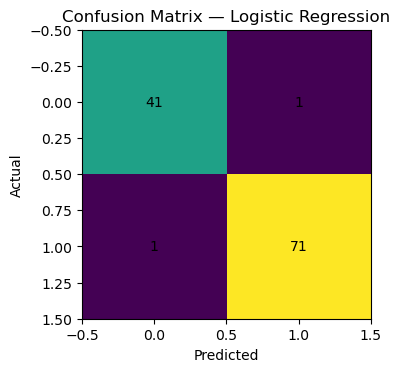

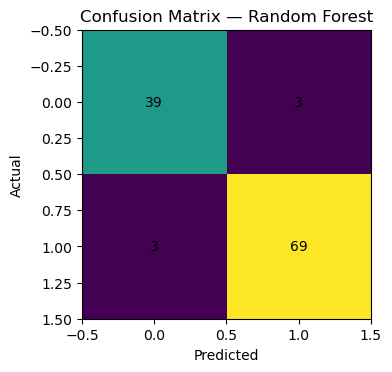

In [8]:

# Confusion matrices
import matplotlib.pyplot as plt

cm_log = confusion_matrix(y_test, log_pred)
cm_rf  = confusion_matrix(y_test, rf_pred)

for name, cm in [("Logistic Regression", cm_log), ("Random Forest", cm_rf)]:
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap=None)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()


<Figure size 500x400 with 0 Axes>

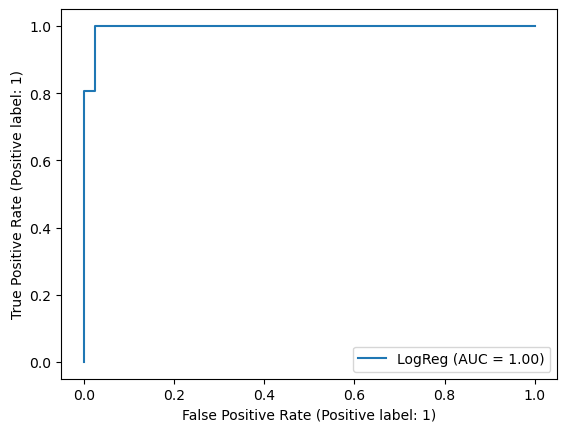

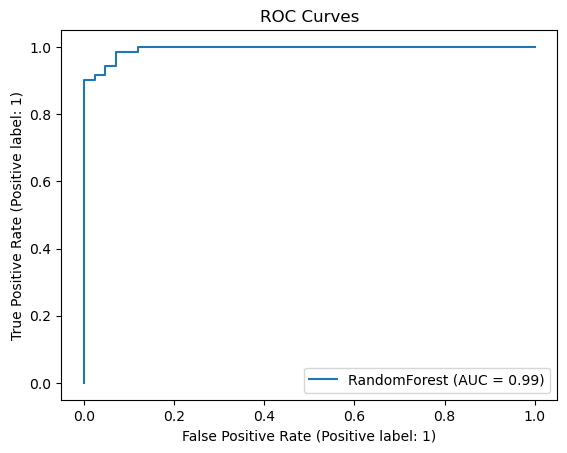

In [9]:

# ROC Curves
plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, log_proba, name="LogReg")
RocCurveDisplay.from_predictions(y_test, rf_proba, name="RandomForest")
plt.title("ROC Curves")
plt.show()



### Feature Importance / Interpretability

- For **Logistic Regression**, we inspect the absolute value of coefficients (after scaling) as a proxy for importance.  
- For **Random Forest**, we check `feature_importances_`.


In [10]:

import numpy as np
import pandas as pd

# Extract LR coefficients
log_clf = logreg_pipe.named_steps["clf"]
scaler = logreg_pipe.named_steps["scaler"]

coef = pd.Series(np.abs(log_clf.coef_[0]), index=X.columns).sort_values(ascending=False)

# RF importances
rf_imp = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

coef.head(10), rf_imp.head(10)


(worst texture           1.248332
 radius error            1.084279
 worst area              0.953706
 worst concave points    0.948458
 worst radius            0.945125
 worst symmetry          0.935219
 area error              0.934894
 worst concavity         0.828861
 worst perimeter         0.761424
 worst smoothness        0.752978
 dtype: float64,
 worst perimeter         0.137344
 worst area              0.137312
 worst concave points    0.115502
 mean concave points     0.091774
 worst radius            0.084111
 mean radius             0.062741
 mean perimeter          0.049680
 mean concavity          0.044142
 mean area               0.040508
 worst concavity         0.034837
 dtype: float64)

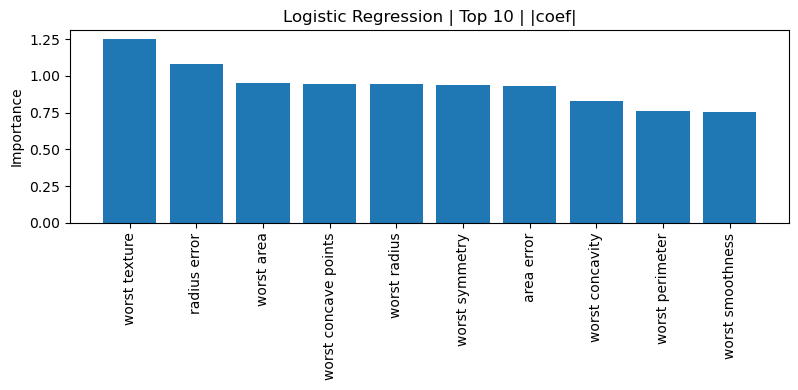

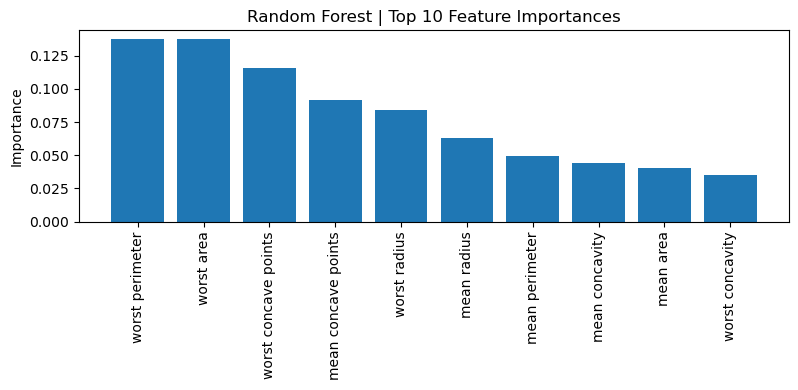

In [11]:

# Plot top-10 features for each model (matplotlib bar charts)
for title, series in [("Logistic Regression | Top 10 | |coef|", coef.head(10)),
                      ("Random Forest | Top 10 Feature Importances", rf_imp.head(10))]:
    plt.figure(figsize=(8,4))
    plt.bar(series.index, series.values)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()



## 6) Evaluation

We compare performance and discuss whether the model meets the business goals (high recall for malignant tumors with acceptable precision).


In [12]:

import pandas as pd

results = pd.DataFrame([log_metrics, rf_metrics], index=["Logistic Regression", "Random Forest"])
results


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.982456,0.986111,0.986111,0.986111,0.995370
Random Forest,0.947368,0.958333,0.958333,0.958333,0.993717



**Interpretation Guide**  
- **Recall** (for class 1 = benign): By default, scikit-learn treats the positive class as label `1`.  
  If we specifically care about catching **malignant** (`0`) cases, we can flip labels or compute class-specific recall using `pos_label=0` when needed.  
- **ROC-AUC** close to 1.0 is excellent; above 0.95 is typically strong on this dataset.
- Choose a model with **high recall for malignant** (or adjust the decision threshold) and good precision.

**Next Steps**
- Calibrate probabilities and adjust decision threshold for the clinical objective.
- Cross-validation and hyperparameter tuning (GridSearchCV / RandomizedSearchCV).
- Fairness and robustness checks.



## 7) Deployment Ideas

- Wrap the chosen model in a simple **FastAPI** or **Flask** service.
- Add model versioning and monitoring (drift detection, performance tracking).
- Provide clear documentation and an interpretation report for clinicians.
